In [1]:
!pip install -q transformers
!pip install -q datasets jiwer

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
python-levenshtein 0.20.7 requires Levenshtein==0.20.7, but you have levenshtein 0.20.2 which is incompatible.


In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["no_deprecation_warning"] ="true"

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers import TrOCRProcessor,VisionEncoderDecoderModel, AutoTokenizer, ViTFeatureExtractor, AutoModel
import pandas as pd
from tqdm.notebook import tqdm
from datasets import load_metric
import torch.optim as optim

# Preparing data

## Load Train Data

In [4]:
df_t = pd.read_excel('../input/khattpilottest/KHATT-Pilot/Groundtruth-Unicode.xlsx',sheet_name=0,header=None)
df_t.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df_t.head()

,file_name,text
0,AHTD3A0001_Para2_3.tif,من العذاب في الآخرة، وأفضل ما رزقهم الله تعالى...
1,AHTD3A0001_Para2_4.tif,لجميع الأشياء والذي لا يقدر أحدٌ في الدنيا على...
2,AHTD3A0001_Para3_1.tif,فقال له إنك في منازل آبائك وأجدادك من الجبابر...
3,AHTD3A0001_Para3_2.tif,قبلك، وشيدوه دونك، وبنوا القلاع والحصون، ومهدو...
4,AHTD3A0002_Para2_1.tif,وكذلك طالب الآخرة مجتهد في العمل المنجي به روح...


## Load Validation Data

In [5]:
df_v = pd.read_excel('../input/khattpilottest/KHATT-Pilot/Groundtruth-Unicode.xlsx',sheet_name=1,header=None)
df_v.rename(columns={0: "file_name", 1: "text"}, inplace=True)
df_v.head()

,file_name,text
0,AHTD3A0438_Para3_4.tif,وقد كانت حرة نشطة عاشت أمدا طويلاّ كما يظهر من...
1,AHTD3A0441_Para2_1.tif,وهي مساحات من الأرضين تعلوها رمال حمر في الغال...
2,AHTD3A0441_Para2_2.tif,إلى حضرموت ومهرة في الجنوب، واليمن في الغرب، و...
3,AHTD3A0441_Para2_3.tif,سلاسل من التلال الرملية ذات ارتفاعات مختلفة، ت...
4,AHTD3A0441_Para2_4.tif,الرياح، وتغطي مساحات واسعة من الأرض ويمكن الع...


## Create Data Tensors

In [6]:
class KHATDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length",
                                          truncation=True,
                                          max_length=self.max_target_length).input_ids
        # important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [7]:
tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
feature_extractor=ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")
processor = TrOCRProcessor(feature_extractor = feature_extractor, tokenizer = tokenizer)
train_dataset = KHATDataset(root_dir='../input/khattpilottest/KHATT-Pilot/Line Images/Line Images/',
                           df=df_t,
                           processor=processor)
eval_dataset = KHATDataset(root_dir='../input/khattpilottest/KHATT-Pilot/Line Images/Line Images/',
                           df=df_v,
                           processor=processor)


Downloading:   0%|          | 0.00/611 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/384 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/703k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.20M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/160 [00:00<?, ?B/s]

## Correctness Check

In [8]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))

Number of training examples: 1400
Number of validation examples: 233


In [9]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)
encoding = eval_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])
pixel_values torch.Size([3, 224, 224])
labels torch.Size([128])


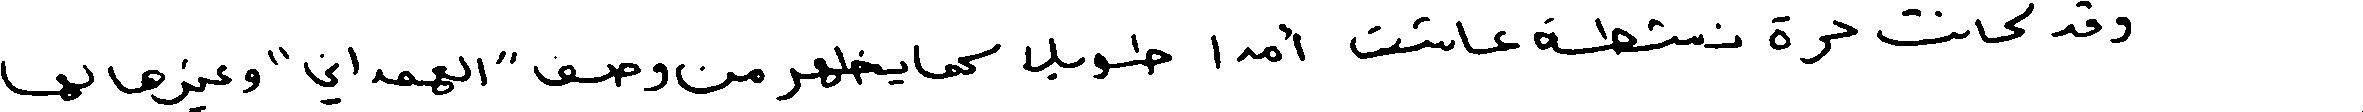

In [10]:
image = Image.open(train_dataset.root_dir + df_v['file_name'][0]).convert("RGB")
image

In [11]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)
print(labels)

وقد كانت حرة نشطة عاشت أمدا كما يظهر من وصف " الهمداني " وغيرها لها
tensor([   33, 35216, 46656,   566,   251,  6892,   251,  3402,   210,  7529,
          195,    32,   506,  3499,   290,  1790,    37, 21436, 23361,    37,
        52159,  2331, 52578,    34,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    31,
           31,    31,    31,    31,    31,    31,    31,    31,    31,    

## Dataloader for Model

In [12]:
#train_dataloader = DataLoader(train_dataset, batch_size=8)
#eval_dataloader = DataLoader(eval_dataset, batch_size=8)

# Model Training

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# initialize the encoder from a pretrained ViT and the decoder from a pretrained BERT model. 
# Note that the cross-attention layers will be randomly initialized, and need to be fine-tuned on a downstream dataset
model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224", "aubmindlab/bert-base-arabertv2")
print(model.config.decoder.decoder_start_token_id)
model.to(device)

Downloading:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/330M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at aubmindlab/bert-base-arabertv2 were not used when initializing BertLMHeadModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['bert.encoder.layer.10.crossattention.self.value.weight', 'bert.encoder.layer.4.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.4.crossattention.self.query.bias', 'bert.encoder.layer.7.crossattention.se

None


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out

In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
wer_metric = load_metric("wer")

def compute_wer(pred):
    
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)


    return  {"wer": wer}

In [16]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=100,
)

In [17]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.tokenizer,
    args=training_args,
    compute_metrics=compute_wer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()
#trainer.save_model('./m')

Using cuda_amp half precision backend
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1400
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 525
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss,Validation Loss,Wer
100,6.955800,6.950966,1.113402
200,6.496100,6.698384,1.556701
300,6.606200,6.776637,2.057532
400,6.441600,6.774720,1.793482
500,6.634700,6.765750,1.658131


***** Running Evaluation *****
  Num examples = 233
  Batch size = 8
***** Running Evaluation *****
  Num examples = 233
  Batch size = 8
***** Running Evaluation *****
  Num examples = 233
  Batch size = 8
***** Running Evaluation *****
  Num examples = 233
  Batch size = 8
***** Running Evaluation *****
  Num examples = 233
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


Saving model checkpoint to ./m
Configuration saved in ./m/config.json
Model weights saved in ./m/pytorch_model.bin
tokenizer config file saved in ./m/tokenizer_config.json
Special tokens file saved in ./m/special_tokens_map.json


# Testing

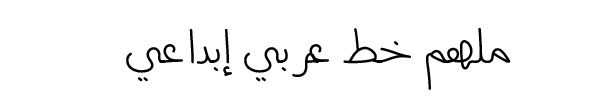

In [18]:
import requests
from io import StringIO
#url = '../input/khattpilottest/KHATT-Pilot/Line Images/Line Images/AHTD3A0001_Para2_3.tif'
url='https://arabicfont.net/wp-content/uploads/2017/05/molhim-arabic-font.jpg'
img = Image.open(requests.get(url, stream=True).raw).convert("RGB")
#image = Image.open(url).convert("RGB")
img

In [19]:
#model = VisionEncoderDecoderModel.from_pretrained("./m")
#model= model.to(device)
p = processor(img, return_tensors="pt").pixel_values
p= p.to(device)
generated_ids = model.generate(p)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)
print(generated_ids)

loading configuration file ./m/config.json
Model config VisionEncoderDecoderConfig {
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_name_or_path": "aubmindlab/bert-base-arabertv2",
    "add_cross_attention": true,
    "architectures": [
      "BertForMaskedLM"
    ],
    "attention_probs_dropout_prob": 0.1,
    "bad_words_ids": null,
    "bos_token_id": null,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": null,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": null,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidden_act": "gelu",
    "hidden_dropout_prob": 0.1,
    "hidden_size": 768,
    "id2label": {
      "0": "LABEL_0",
      "1": "LABEL_1"
    },
    "initializer_range":

##ة في ، من والةةة ،ةة منةة فيةةةة المةة "ةةةةهةة العةةاةةتةةاتةةهاة
tensor([[  33,   33,   33,  251,   33,   33,   32,   33,   33,  289,   33,   33,
          130,   33,   33,  290,   33,   33, 6689,  251,  251,  251,  130,  251,
          251,  290,  251,  251,  289,  251,  251,   34,  251,  251, 7214,  251,
          251,   37,  251,  251,   32,  251,  251,  223,  251,  251, 6958,  251,
          251,  195,  251,  251,  210,  251,  251,  440,  251,  251, 2331,   34,
           34,   34,  251,   34]], device='cuda:0')
